In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeval-2016-absa-task5/Laptops_Train_sb1.xml
/kaggle/input/semeval-2016-absa-task5/restaurants_test_sb1.xml
/kaggle/input/semeval-2016-absa-task5/laptops_test_sb1.xml
/kaggle/input/semeval-2016-absa-task5/restaurants_train_sb1.xml


In [2]:
# 📦 1. Install & Import Libraries
!pip install -q transformers

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import torch
import json
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim import AdamW
from tqdm import tqdm
# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

2025-05-16 06:41:18.888865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747377679.084230      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747377679.142142      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [6]:
# 📂 2. Load and Parse SemEval XML Data
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for review in root.findall('Review'):
        for sentence in review.find('sentences').findall('sentence'):
            text = sentence.find('text').text
            opinions = sentence.find('Opinions')
            aspects = []
            if opinions is not None:
                for opinion in opinions.findall('Opinion'):
                    category = opinion.attrib.get('category')
                    polarity = opinion.attrib.get('polarity')
                    if polarity:
                        aspects.append({'term': category, 'polarity': polarity})
            if aspects:
                data.append({'text': text, 'aspects': aspects})
    return data

train_data = parse_xml("/kaggle/input/semeval-2016-absa-task5/restaurants_train_sb1.xml")
test_data = parse_xml("/kaggle/input/semeval-2016-absa-task5/restaurants_test_sb1.xml")


In [8]:
# 🧾 3. Convert to DataFrame
def create_dataframe(data):
    rows = []
    label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
    for item in data:
        for asp in item['aspects']:
            rows.append({
                'text': item['text'],
                'aspect': asp['term'],
                'label': label_map[asp['polarity']]
            })
    return pd.DataFrame(rows)

train_df = create_dataframe(train_data)
test_df = create_dataframe(test_data)
display(train_df.head())

,text,aspect,label
0,Judging from previous posts this used to be a ...,RESTAURANT#GENERAL,1
1,"We, there were four of us, arrived at noon - t...",SERVICE#GENERAL,1
2,"They never brought us complimentary noodles, i...",SERVICE#GENERAL,1
3,The food was lousy - too sweet or too salty an...,FOOD#QUALITY,1
4,The food was lousy - too sweet or too salty an...,FOOD#STYLE_OPTIONS,1


In [9]:
# 4. Load Tokenizer & Model (Offline)
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', use_fast=True)
config = RobertaConfig.from_pretrained('roberta-base', num_labels=3)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

model.to(device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [11]:
# 5. Define Dataset Class
class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        row = self.data.iloc[index]
        encoding = self.tokenizer(
            row['text'] + ' </s> ' + row['aspect'],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

In [12]:
# 🔀 6. Train/Val Split & Loaders
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)
train_set = ABSADataset(train_data, tokenizer)
val_set = ABSADataset(val_data, tokenizer)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)


In [13]:
# 🏋️‍♀️ 7. Training Loop
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_list = []
for epoch in range(30):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_loader)
    loss_list.append(epoch_loss)
    print(f"Epoch {epoch+1} Average Loss: {epoch_loss:.4f}")


Epoch 1: 100%|██████████| 141/141 [00:30<00:00,  4.59it/s]


Epoch 1 Average Loss: 0.5607


Epoch 2: 100%|██████████| 141/141 [00:29<00:00,  4.72it/s]


Epoch 2 Average Loss: 0.3458


Epoch 3: 100%|██████████| 141/141 [00:29<00:00,  4.70it/s]


Epoch 3 Average Loss: 0.2729


Epoch 4: 100%|██████████| 141/141 [00:30<00:00,  4.69it/s]


Epoch 4 Average Loss: 0.2219


Epoch 5: 100%|██████████| 141/141 [00:30<00:00,  4.68it/s]


Epoch 5 Average Loss: 0.1956


Epoch 6: 100%|██████████| 141/141 [00:30<00:00,  4.66it/s]


Epoch 6 Average Loss: 0.1743


Epoch 7: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 7 Average Loss: 0.1577


Epoch 8: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 8 Average Loss: 0.1760


Epoch 9: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 9 Average Loss: 0.1489


Epoch 10: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 10 Average Loss: 0.1229


Epoch 11: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 11 Average Loss: 0.1082


Epoch 12: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 12 Average Loss: 0.1201


Epoch 13: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 13 Average Loss: 0.0986


Epoch 14: 100%|██████████| 141/141 [00:30<00:00,  4.66it/s]


Epoch 14 Average Loss: 0.0850


Epoch 15: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 15 Average Loss: 0.0864


Epoch 16: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 16 Average Loss: 0.0769


Epoch 17: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 17 Average Loss: 0.0672


Epoch 18: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 18 Average Loss: 0.0711


Epoch 19: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 19 Average Loss: 0.0751


Epoch 20: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 20 Average Loss: 0.0632


Epoch 21: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 21 Average Loss: 0.0522


Epoch 22: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 22 Average Loss: 0.0471


Epoch 23: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 23 Average Loss: 0.0566


Epoch 24: 100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


Epoch 24 Average Loss: 0.0946


Epoch 25: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 25 Average Loss: 0.0659


Epoch 26: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 26 Average Loss: 0.0497


Epoch 27: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 27 Average Loss: 0.0561


Epoch 28: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 28 Average Loss: 0.0603


Epoch 29: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]


Epoch 29 Average Loss: 0.0567


Epoch 30: 100%|██████████| 141/141 [00:30<00:00,  4.65it/s]

Epoch 30 Average Loss: 0.0417


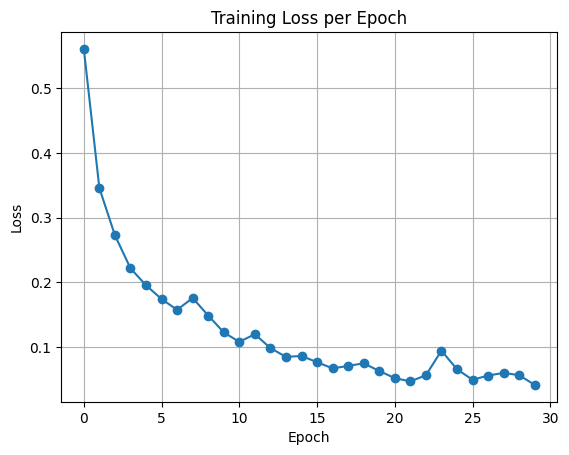

In [14]:
#  8. Loss Visualization
plt.plot(loss_list, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [15]:
# 9. Validation Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(output.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['positive', 'negative', 'neutral']))


              precision    recall  f1-score   support

    positive       0.94      0.89      0.92       180
    negative       0.82      0.73      0.78        64
     neutral       0.30      1.00      0.47         7

    accuracy                           0.86       251
   macro avg       0.69      0.88      0.72       251
weighted avg       0.89      0.86      0.87       251



In [16]:
# 10. Predict on Test Set
test_dataset = ABSADataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())

label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}
test_df['predicted'] = test_preds
test_df['predicted_label'] = test_df['predicted'].map(label_map_rev)
display(test_df[['text', 'aspect', 'predicted_label']].sample(10))   # random 10


,text,aspect,predicted_label
275,Seattle's BEST Winelist,DRINKS#STYLE_OPTIONS,positive
246,"– The food is here is incredible, though the q...",FOOD#QUALITY,positive
340,Two thumbs up!,FOOD#QUALITY,positive
359,A cozy spot for 2,AMBIENCE#GENERAL,positive
70,Very disappointed.,RESTAURANT#GENERAL,negative
207,"Even the chickpeas, which I normally find too ...",FOOD#QUALITY,positive
315,Atmosphere was nice.,AMBIENCE#GENERAL,positive
296,– Mioposto has a very creative & delicious piz...,FOOD#STYLE_OPTIONS,positive
376,Love the enchiladas and chicken soup - and be ...,FOOD#QUALITY,positive
283,The food is not what it once was (potions have...,FOOD#STYLE_OPTIONS,negative


In [17]:
# 11. Save Trained Model & Tokenizer
model.save_pretrained("saved_roberta_model")
tokenizer.save_pretrained("saved_roberta_model")
!cp -r saved_roberta_model /kaggle/working/


cp: 'saved_roberta_model' and '/kaggle/working/saved_roberta_model' are the same file


In [18]:
# 12. Save Training Logs
training_log = {
    "epochs": 3,
    "train_loss_per_epoch": loss_list
}
with open("/kaggle/working/training_log.json", "w") as f:
    json.dump(training_log, f)

print("Model, tokenizer, and training log saved to /kaggle/working/")


Model, tokenizer, and training log saved to /kaggle/working/


In [19]:
test_df['true_label'] = test_df['label'].map(label_map_rev)
print(classification_report(test_df['label'], test_df['predicted'], target_names=['positive', 'negative', 'neutral']))


              precision    recall  f1-score   support

    positive       0.96      0.89      0.93       611
    negative       0.83      0.84      0.84       204
     neutral       0.37      0.73      0.49        44

    accuracy                           0.87       859
   macro avg       0.72      0.82      0.75       859
weighted avg       0.90      0.87      0.88       859



              precision    recall  f1-score   support

    positive       0.96      0.89      0.93       611
    negative       0.83      0.84      0.84       204
     neutral       0.37      0.73      0.49        44

    accuracy                           0.87       859
   macro avg       0.72      0.82      0.75       859
weighted avg       0.90      0.87      0.88       859



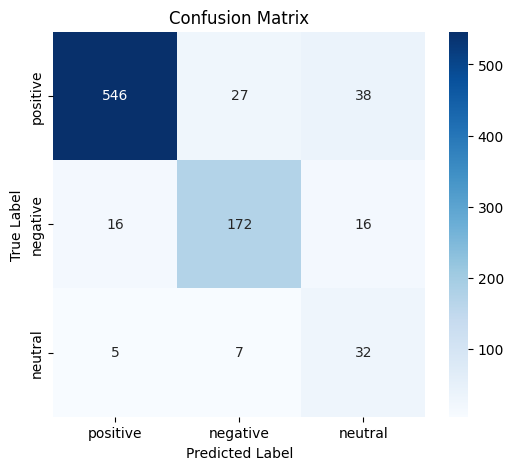

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reverse label map (if not already defined)
label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}
test_df['true_label'] = test_df['label'].map(label_map_rev)
test_df['predicted_label'] = test_df['predicted'].map(label_map_rev)

# Print classification report
print(classification_report(
    test_df['label'], 
    test_df['predicted'], 
    target_names=['positive', 'negative', 'neutral']
))

# Compute confusion matrix
cm = confusion_matrix(test_df['true_label'], test_df['predicted_label'], labels=['positive', 'negative', 'neutral'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [20]:
print(train_data['label'].value_counts().sort_index())


label
0    1477
1     685
2      94
Name: count, dtype: int64


In [21]:
label_map_rev = {0: 'positive', 1: 'negative', 2: 'neutral'}
train_data['label'].map(label_map_rev).value_counts()


label
positive    1477
negative     685
neutral       94
Name: count, dtype: int64